In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import k_means

Let's read the dataset. You need to download the dataset (Scenario 10) from here https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-51/capture20110818.pcap.netflow.labeled and put it in the dataset folder. We rename the file to `capture-scenario10.pcap.netflow.labeled`

In [219]:
dataset = pd.read_csv('dataset/capture-scenario10.pcap.netflow.labeled', delim_whitespace=True,skiprows=1,header=None)
dataset.columns = ["Date","Start","Duration","Protocol", "Source_IP","->","Destination_IP", "Flags","Tos","Packets"
                            ,"Bytes", "Flows","Label"]

In [220]:
dataset.head()

,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label
0,2011-08-18,10:19:13.328,0.002,TCP,147.32.86.166:33426,->,212.24.150.110:25443,FRPA_,0,4,321,1,Background
1,2011-08-18,10:19:13.328,4.995,UDP,82.39.2.249:41915,->,147.32.84.59:43087,INT,0,617,40095,1,Background
2,2011-08-18,10:19:13.329,4.996,UDP,147.32.84.59:43087,->,82.39.2.249:41915,INT,0,1290,1909200,1,Background
3,2011-08-18,10:19:13.330,0.000,TCP,147.32.86.166:42020,->,147.32.192.34:993,A_,0,1,66,1,Background
4,2011-08-18,10:19:13.330,0.000,TCP,212.24.150.110:25443,->,147.32.86.166:33426,FPA_,0,2,169,1,Background


First, let's remove all background flows

In [221]:
dataset = dataset[dataset['Label'] != 'Background']
dataset.head()

,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label
20,2011-08-18,10:19:13.347,4.985,TCP,147.32.80.13:80,->,147.32.85.88:56949,PA_,0,91,86277,1,LEGITIMATE
51,2011-08-18,10:19:13.392,0.000,TCP,147.32.86.110:48102,->,74.125.232.214:443,A_,0,1,66,1,LEGITIMATE
57,2011-08-18,10:19:13.411,4.921,TCP,147.32.85.88:56949,->,147.32.80.13:80,A_,0,49,3234,1,LEGITIMATE
73,2011-08-18,10:19:13.460,4.742,TCP,147.32.84.59:2768,->,74.125.108.208:80,A_,0,118,7080,1,LEGITIMATE
75,2011-08-18,10:19:13.486,0.000,TCP,147.32.84.59:56058,->,74.125.232.215:443,A_,0,1,60,1,LEGITIMATE


In [222]:
len(dataset)

645358

In [223]:
# remove port information
dataset['Source_IP'] = dataset['Source_IP'].apply(lambda x: x.split(":")[0])
dataset['Destination_IP'] = dataset['Destination_IP'].apply(lambda x: x.split(":")[0])
dataset.head()

,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label
20,2011-08-18,10:19:13.347,4.985,TCP,147.32.80.13,->,147.32.85.88,PA_,0,91,86277,1,LEGITIMATE
51,2011-08-18,10:19:13.392,0.000,TCP,147.32.86.110,->,74.125.232.214,A_,0,1,66,1,LEGITIMATE
57,2011-08-18,10:19:13.411,4.921,TCP,147.32.85.88,->,147.32.80.13,A_,0,49,3234,1,LEGITIMATE
73,2011-08-18,10:19:13.460,4.742,TCP,147.32.84.59,->,74.125.108.208,A_,0,118,7080,1,LEGITIMATE
75,2011-08-18,10:19:13.486,0.000,TCP,147.32.84.59,->,74.125.232.215,A_,0,1,60,1,LEGITIMATE


In [224]:
# convert to datetime
dataset['Start'] = dataset['Date'] + ' ' + dataset['Start']
dataset['Start'] = pd.to_datetime(dataset['Start'])
dataset.head()

,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label
20,2011-08-18,2011-08-18 10:19:13.347,4.985,TCP,147.32.80.13,->,147.32.85.88,PA_,0,91,86277,1,LEGITIMATE
51,2011-08-18,2011-08-18 10:19:13.392,0.000,TCP,147.32.86.110,->,74.125.232.214,A_,0,1,66,1,LEGITIMATE
57,2011-08-18,2011-08-18 10:19:13.411,4.921,TCP,147.32.85.88,->,147.32.80.13,A_,0,49,3234,1,LEGITIMATE
73,2011-08-18,2011-08-18 10:19:13.460,4.742,TCP,147.32.84.59,->,74.125.108.208,A_,0,118,7080,1,LEGITIMATE
75,2011-08-18,2011-08-18 10:19:13.486,0.000,TCP,147.32.84.59,->,74.125.232.215,A_,0,1,60,1,LEGITIMATE


In [144]:
# infected host list from https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-51/
infected_hosts = ["147.32.84.165", "147.32.84.191", "147.32.84.192", "147.32.84.193", "147.32.84.204", "147.32.84.205", "147.32.84.206", "147.32.84.207", "147.32.84.208", "147.32.84.209"]

In [145]:
infected_flow_sample = dataset[(dataset['Source_IP'] == "147.32.84.165") | (dataset['Destination_IP'] == "147.32.84.165")]
normal_flow_sample = dataset[(dataset['Source_IP'] == "147.32.84.170") & (dataset['Label'] == 'LEGITIMATE')]

In [146]:
infected_flow_sample.head()

,Date,Start,Duration,Protocol,Source_IP,->,Destination_IP,Flags,Tos,Packets,Bytes,Flows,Label
299473,2011-08-18,2011-08-18 10:37:58.448,0.000,UDP,147.32.84.165,->,147.32.80.9,INT,0,1,64,1,Botnet
299474,2011-08-18,2011-08-18 10:37:58.448,0.000,UDP,147.32.80.9,->,147.32.84.165,INT,0,1,139,1,Botnet
300156,2011-08-18,2011-08-18 10:38:00.695,0.000,UDP,147.32.84.165,->,147.32.80.9,INT,0,1,87,1,Botnet
300158,2011-08-18,2011-08-18 10:38:00.705,0.000,UDP,147.32.80.9,->,147.32.84.165,INT,0,1,503,1,Botnet
300159,2011-08-18,2011-08-18 10:38:00.706,0.043,TCP,147.32.84.165,->,74.125.232.206,SRPA_,0,4,629,1,Botnet


In [196]:
infected_flow_sample['Duration'].describe()

count    29526.000000
mean         0.608945
std          1.475436
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.999000
Name: Duration, dtype: float64

In [199]:
def plot_elbow(samples, feature="Packets", max_k=10):
    datapoints = samples[feature].sort_values()
    sse_list = []
    for k in range(1,max_k+1):
        sse = 0
        _,_,sse = k_means(np.array(datapoints).reshape(-1,1), k)
        sse_list.append(sse)
    plt.figure()
    plt.plot(range(1,len(sse_list)+1), sse_list)
    plt.xlabel("number of clusters")
    plt.ylabel("sum of squared distances")
    plt.title("Cluster Size for " + feature)

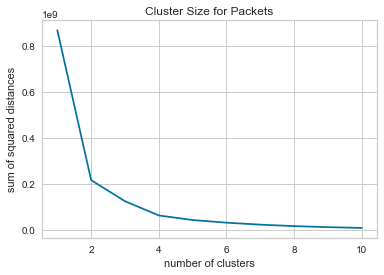

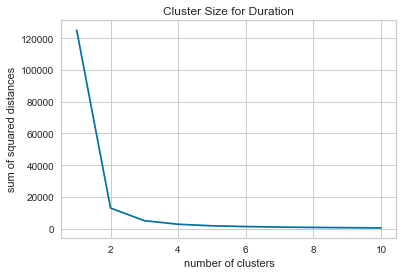

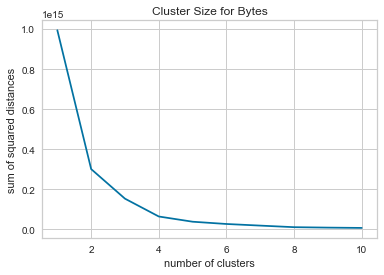

In [201]:
samples = dataset.sample(frac=0.1) # use only 10% of data
plot_elbow(samples, "Packets", 10)
plot_elbow(samples, "Duration", 10)
plot_elbow(samples, "Bytes", 10)

We can see that the elbow for all three features (duration, packets, and bytes) are at cluster=4, so we will use the 25th, 50th, 75th percentile for discretizing these features

In [262]:
# discretize
def discretize(sample, feature, percentile_ranks=[25,50,75]):
    feature_values = sample[feature]
    percentiles = [np.percentile(feature_values,x) for x in percentile_ranks]
    print(percentiles)
    discrete_output = []
    for x in list(feature_values):
        discrete_value = None
        
        for idx,percentile in enumerate(percentiles):
            print("x:",x)
            print("percentile:",percentile)
            print("idx:", idx)
            if x <= percentile and discrete_value is None:
                discrete_value = idx
                break;
                
        if discrete_value is None:
            discrete_value = len(percentiles)
        
        print('discrete_value:',discrete_value)
        discrete_output.append(discrete_value)
    
    return pd.Series(discrete_output, dtype=int)

In [ ]:
dataset['d_Packets'] = discretize(dataset, "Packets")
dataset['d_Bytes'] = discretize(dataset, "Bytes")
dataset['d_Duration'] = discretize(dataset, "Duration")

map_protocol = {"TCP": 0, "UDP": 1, "ICMP": 2}
dataset['d_Protocol'] = dataset['Protocol'].apply(lambda x: map_protocol[x])

[1.0, 1.0, 4.0]
x: 91
percentile: 1.0
idx: 0
x: 91
percentile: 1.0
idx: 1
x: 91
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 49
percentile: 1.0
idx: 0
x: 49
percentile: 1.0
idx: 1
x: 49
percentile: 4.0
idx: 2
discrete_value: 3
x: 118
percentile: 1.0
idx: 0
x: 118
percentile: 1.0
idx: 1
x: 118
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 30
percentile: 1.0
idx: 0
x: 30
percentile: 1.0
idx: 1
x: 30
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 8
percentile: 1.0
idx: 0
x: 8
percentile: 1.0
idx: 1
x: 8
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx:

x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 16
percentile: 1.0
idx: 0
x: 16
percentile: 1.0
idx: 1
x: 16
percentile: 4.0
idx: 2
discrete_value: 3
x: 21
percentile: 1.0
idx: 0
x: 21
percentile: 1.0
idx: 1
x: 21
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 17
percentile: 1.0
idx: 0
x: 17
percentile: 1.0
idx: 1
x: 17
percentile: 4.0
idx: 2
discrete_value: 3
x: 14
percentile: 1.0
idx: 0
x: 14
percentile: 1.0
idx: 1
x: 14
percentile: 4.0
idx: 2
discrete_value: 3
x: 119
percentile: 1.0
idx: 0
x: 119
percentile: 1.0
idx: 1
x: 119
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0

percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
id

idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 60
percentile: 1.0
idx: 0
x: 60
percentile: 1.0
idx: 1
x: 60
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 8
percentile: 1.0
idx: 0
x: 8
percentile: 1.0
idx: 1
x: 8
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 53
percentile: 1.0
idx: 0
x: 53
percentile: 1.0
idx: 1
x: 53
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 96
percentile: 1.0
idx: 0
x: 96
percentile: 1.0
idx: 1
x: 96
percent

x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 134
percentile: 1.0
idx: 0
x: 134
percentile: 1.0
idx: 1
x: 134
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percent

discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 9
percentile: 1.0
idx: 0
x: 9
percentile: 1.0
idx: 1
x: 9
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 126
percentile: 1.0
idx: 0
x: 126
percentile: 1.0
idx: 1
x: 126
percentile: 4.0
idx: 2
discrete_value: 3
x: 19
percentile: 1.0
idx: 0
x: 19
percentile: 1.0
idx: 1
x: 19
percentile: 4.0
idx: 2
discrete_value: 3
x: 17
percentile: 1.0
idx: 0
x: 17
percentile: 1.0
idx: 1
x: 17
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile:

idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 11
percentile: 1.0
idx: 0
x: 11
percentile: 1.0
idx: 1
x: 11
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4

percentile: 1.0
idx: 1
x: 9
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
pe

discrete_value: 2
x: 29
percentile: 1.0
idx: 0
x: 29
percentile: 1.0
idx: 1
x: 29
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 128
percentile: 1.0
idx: 0
x: 128
percentile: 1.0
idx: 1
x: 128
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 29
percentile: 1.0
idx: 0
x: 29
percentile: 1.0
idx: 1
x: 29
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile:

x: 495
percentile: 1.0
idx: 1
x: 495
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 53
percentile: 1.0
idx: 0
x: 53
percentile: 1.0
idx: 1
x: 53
percentile: 4.0
idx: 2
discrete_value: 3
x: 95
percentile: 1.0
idx: 0
x: 95
percentile: 1.0
idx: 1
x: 95
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 8
percentile: 1.0
idx: 0
x: 8
percentile: 1.0
idx: 1
x: 8
per

percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percent

idx: 0
discrete_value: 0
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 14
percentile: 1.0
idx: 0
x: 14
percentile: 1.0
idx: 1
x: 14
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile

discrete_value: 3
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 22
percentile: 1.0
idx: 0
x: 22
percentile: 1.0
idx: 1
x: 22
percentile: 4.0
idx: 2
discrete_value: 3
x: 29
percentile: 1.0
idx: 0
x: 29
percentile: 1.0
idx: 1
x: 29
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 27
percentile: 1.0
idx: 0
x: 27
percentile: 1.0
idx: 1
x: 27
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3


percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 5
percentile: 1.0
idx: 0
x: 5
percenti

idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 19
percentile: 1.0
idx: 0
x: 19
percentile: 1.0
idx: 1
x: 19
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
per

x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 125
percentile: 1.0
idx: 0
x: 125
percentile: 1.0
idx: 1
x: 125
percentile: 4.0
idx: 2
discrete_value: 3
x: 357
percentile: 1.0
idx: 0
x: 357
percentile: 1.0
idx: 1
x: 357
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile:

percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 15
percentile: 1.0
idx: 0
x: 15
percentile: 1.0
idx: 1
x: 15
percentile: 4.0
idx: 2
discrete_value: 3
x: 54
percentile: 1.0
idx: 0
x: 54
percentile: 1.0
idx: 1
x: 54
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discret

percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1


idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx:

x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 326
percentile: 1.0
idx: 0
x: 326
percentile: 1.0
idx: 1
x: 326
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
di

percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 13
percentile: 1.0
idx: 0
x: 13
percentile: 1.0
idx: 1
x: 13
percentile: 4.0
idx: 2
discrete_value: 3
x: 17
percentile: 1.0
idx: 0
x: 17
percentile: 1.0
idx: 1
x: 17
percentile: 4.0
idx: 2
discrete_value: 3
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 16
percentile: 1.0
idx: 0
x: 16
percentile: 1.0
idx: 1
x: 16
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
disc

percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 300
pe

x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 22
percentile: 1.0
idx: 0
x: 22
percentile: 1.0
idx: 1
x: 22
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 66
percentile: 1.0
idx: 0
x: 66
percentile: 1.0
idx: 1
x: 66
percentile: 4.0
idx: 2
discrete_value: 3
x: 243
percentile: 1.0
idx: 0
x: 243
percentile: 1.0
idx: 1
x: 243
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile:

x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 5
perce

percentile: 4.0
idx: 2
discrete_value: 2
x: 322
percentile: 1.0
idx: 0
x: 322
percentile: 1.0
idx: 1
x: 322
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile:

x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 11
percentile: 1.0
idx: 0
x: 11
percentile: 1.0
idx: 1
x: 11
percentile: 4.0
idx: 2
discrete_value: 3
x: 14
percentile: 1.0
idx: 0
x: 14
percentile: 1.0
idx: 1
x: 14
percentile: 4.0
idx: 2
discrete_value: 3
x: 50
percentile: 1.0
idx: 0
x: 50
percentile: 1.0
idx: 1
x: 50
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 127
percentile: 1.0
idx: 0
x: 127
percentile: 1.0
idx: 1
x: 127
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 5
percentile: 1.0
idx: 0
x: 5
percentile

x: 13
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
pe

idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 9
percentile: 1.0
idx: 0
x: 9
percentile: 1.0
idx: 1
x: 9
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 23
percentile: 1.0
idx: 0
x: 23
percentile: 1.0
idx: 1
x: 23
percentile: 4.0
idx: 2
discrete_value: 3
x: 22
percentile: 1.0
idx: 0
x: 22
percentile: 1.0
idx: 1
x: 22
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
p

percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
id

percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 15
percentile: 1.0
idx: 0
x: 15
percentile: 1.0
idx: 1
x: 15
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_v

idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 11
percentile: 1.0
idx: 0
x: 11
percentile: 1.0
idx: 1
x: 11
percentile: 4.0
idx: 2
discrete_v

idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 125
percentile: 1.0
idx: 0
x: 125
percentile: 1.0
idx: 1
x: 125
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 91
percentile: 1.0
idx: 0
x: 91
percentile: 1.0
idx: 1
x: 91
percentile: 4.0
idx: 2
discrete_value: 3
x: 52
percentile: 1.0
idx: 0
x: 52
percentile: 1.0
idx: 1
x: 52
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1

idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 11
percentile: 1.0
idx: 0
x: 11
percentile: 1.0
idx: 1
x: 11
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 64
percentile: 1.0
idx: 0
x: 64
percentile: 1.0
idx: 1
x: 64
percentile: 4.0
idx: 2
discrete_value: 3
x: 9
percentile: 1.0
idx: 0
x: 9
percentile: 1.0
idx: 1
x: 9
percentile: 4.0
idx: 2
discrete_value: 3
x: 65
percentile: 1.0
idx: 0
x

percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 14
percentile: 1.0
idx: 0
x: 14
percentile: 1.0
idx: 1
x: 14
percentile: 4.0
idx: 2
discrete_value: 3
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 17
percentile: 1.0
idx: 0
x: 17
percentile: 1.0
idx: 1
x: 17
percentile: 4.0
idx: 2
discrete_value: 3
x: 24
percentile: 1.0
idx: 0
x: 24
percentile: 1.0
idx: 1
x: 24
percentile: 4.0
idx: 2
discrete_value: 3
x: 17
percentile: 1.0
idx: 0
x: 17
percentile: 1.0
idx: 1
x: 17
percentile: 4.0
idx: 2
discrete_value: 3
x: 29
percentile: 1.0
idx: 0
x: 29
percentile: 1.0
idx: 1
x: 29
percentile: 4.0
idx: 2
discrete_value: 3
x: 9
percentile: 1.0
idx: 0
x: 9
percentile: 1.0
idx:

x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 56
percentile: 1.0
idx: 0
x: 56
percentile: 1.0
idx: 1
x: 56
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 86
percentile: 1.0
idx: 0
x: 86
percentile: 1.0
idx: 1
x: 86
percentile: 4.0
idx: 2
discrete_value: 3
x: 36
percentile: 1.0
idx: 0
x: 36
percentile: 1.0
idx: 1
x: 36
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2

x: 94
percentile: 4.0
idx: 2
discrete_value: 3
x: 53
percentile: 1.0
idx: 0
x: 53
percentile: 1.0
idx: 1
x: 53
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 130
percentile: 1.0
idx: 0
x: 130
percentile: 1.0
idx: 1
x: 130
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0


discrete_value: 0
x: 9
percentile: 1.0
idx: 0
x: 9
percentile: 1.0
idx: 1
x: 9
percentile: 4.0
idx: 2
discrete_value: 3
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx:

discrete_value: 3
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 343

x: 9
percentile: 1.0
idx: 0
x: 9
percentile: 1.0
idx: 1
x: 9
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 41
percentile: 1.0
idx: 0
x: 41
percentile: 1.0
idx: 1
x: 41
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 127
percentile: 1.0
idx: 0
x: 127
percentile: 1.0
idx: 1
x: 127
percentile: 4.0
idx: 2
discrete_value: 3
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1

idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 15
percentile: 1.0
idx: 0
x: 15
percentile: 1.0
idx: 1
x: 15
percentile: 4.0
idx: 2
discrete_value: 3
x: 16
percentile: 1.0
idx: 0
x: 16
percentile: 1.0
idx: 1
x: 16
percentile: 4.0
idx: 2
discrete_value: 3
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 17
percentile: 1.0
idx: 0
x: 17
percentile: 1.0
idx: 1
x: 17
percentile: 4.0
idx: 2
discrete_value: 3
x: 15
percentile: 1.0
idx: 0
x: 15
percentile: 1.0
idx: 1
x: 15
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
disc

idx: 1
x: 14
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 31
percentile: 1.0
idx: 0
x: 31
percentile: 1.0
idx: 1
x: 31
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 8
percentile: 1.0
idx: 0
x: 8
percentile: 1.0
idx: 1
x: 8
percentile: 4.0
idx: 2
discret

percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_valu

idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 13
percentile: 1.0
idx: 0
x: 13
percentile: 1.0
idx: 1
x: 13
percentile: 4.0
idx: 2
discrete_value: 3
x: 90
percentile: 1.0
idx: 0
x: 90
percentile: 1.0
idx: 1
x: 90
percentile: 4.0
idx: 2
discrete_value: 3
x: 52
percentile: 1.0
idx: 0
x: 52
percentile: 1.0
idx: 1
x: 52
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x:

percentile: 1.0
idx: 1
x: 28
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 13
percentile: 1.0
idx: 0
x: 13
percentile: 1.0
idx: 1
x: 13
percentile: 4.0
idx: 2
discrete_value: 3
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 19
percentile: 1.0
idx: 0
x: 19
percentile: 1.0
idx: 1
x: 19
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 124
percentile: 1.0
idx: 0
x: 124
percentile: 1.0
idx: 1
x: 124
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x:

x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 18
percentile: 1.0
idx: 0
x: 18
percentile: 1.0
idx: 1
x: 18
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
pe

idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 26
percentile: 1.0
idx: 0
x: 26
percentile: 1.0
idx: 1
x: 26
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 24
percentile: 1.0
idx: 0
x: 24
percentile: 1.0
idx: 1
x: 24
percentile: 4.0
id

percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 100
percentile: 1.0
idx: 0
x: 100
percentile: 1.0
idx: 1
x: 100
percentile: 4.0
idx: 2
discrete_value: 3
x: 122
percentile: 1.0
idx: 0
x: 122
percentile: 1.0
idx: 1
x: 122
percentile: 4.0
idx: 2
discrete_value: 3
x: 90
percentile: 1.0
idx: 0
x: 90
percentile: 1.0
idx: 1
x: 90
percentile: 4.0
idx: 2
discrete_value: 3
x: 106
percentile: 1.0
idx: 0
x: 106
percentile: 1.0
idx: 1
x: 106
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 126
percentile: 1.0
idx: 0
x: 126
percentile: 1.0
idx: 1
x: 126
percentile: 4.0
idx: 

idx: 0
x: 37
percentile: 1.0
idx: 1
x: 37
percentile: 4.0
idx: 2
discrete_value: 3
x: 53
percentile: 1.0
idx: 0
x: 53
percentile: 1.0
idx: 1
x: 53
percentile: 4.0
idx: 2
discrete_value: 3
x: 23
percentile: 1.0
idx: 0
x: 23
percentile: 1.0
idx: 1
x: 23
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 21
percentile: 1.0
idx: 0
x: 21
percentile: 1.0
idx: 1
x: 21
percentile: 4.0
idx: 2
discrete_value: 3
x: 21
percentile: 1.0
idx: 0
x: 21
percentile: 1.0
idx: 1
x: 21
percentile: 4.0
idx: 2
discrete_value: 3
x: 93
percentile: 1.0
idx: 0
x: 93
percentile: 1.0
idx: 1
x: 93
percentile: 4.0
idx: 2
discrete_value: 3
x: 149
percentile: 1.0
idx: 0
x: 149
percentile: 1.0
idx: 1
x: 149
percentile: 4.0
idx: 2
discrete_value: 3
x: 30
percentile: 1.0
idx: 0
x: 30
percentile: 1.0
idx: 1
x: 30
percentile: 4.0
idx: 2
discrete_value: 3
x: 38
percentile: 1.0
idx: 0
x: 38
percentile: 1.0
idx: 1
x: 38
percentile: 4

percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 94
percentile: 1.0
idx: 0
x: 94
percentile: 1.0
idx: 1
x: 94
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 52
percentile: 1.0
idx: 0
x: 52
percentile: 1.0
idx: 1
x: 52
percentile: 4.0
idx: 2
discrete_value: 3

percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
dis

idx: 2
discrete_value: 3
x: 22
percentile: 1.0
idx: 0
x: 22
percentile: 1.0
idx: 1
x: 22
percentile: 4.0
idx: 2
discrete_value: 3
x: 35
percentile: 1.0
idx: 0
x: 35
percentile: 1.0
idx: 1
x: 35
percentile: 4.0
idx: 2
discrete_value: 3
x: 51
percentile: 1.0
idx: 0
x: 51
percentile: 1.0
idx: 1
x: 51
percentile: 4.0
idx: 2
discrete_value: 3
x: 38
percentile: 1.0
idx: 0
x: 38
percentile: 1.0
idx: 1
x: 38
percentile: 4.0
idx: 2
discrete_value: 3
x: 60
percentile: 1.0
idx: 0
x: 60
percentile: 1.0
idx: 1
x: 60
percentile: 4.0
idx: 2
discrete_value: 3
x: 17
percentile: 1.0
idx: 0
x: 17
percentile: 1.0
idx: 1
x: 17
percentile: 4.0
idx: 2
discrete_value: 3
x: 19
percentile: 1.0
idx: 0
x: 19
percentile: 1.0
idx: 1
x: 19
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
per

percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 9
percentile: 1.0
idx: 0
x: 9
percentile: 1.0
idx: 1
x: 9
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 9
percentile: 1.0
idx: 0
x: 9
percentile: 1.0
idx: 1
x: 9
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percenti

percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 8
percentile: 1.0
idx: 0
x: 8
percentile: 1.0
idx: 1
x: 8
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 275
percentile: 1.0
idx: 0
x: 275
percentile: 1.0
idx: 1
x: 275
percentile: 4.0
idx: 2
discrete_value: 3
x: 341
percentile: 1.0
idx: 0
x: 341
percentile: 1.0
idx: 1
x: 341
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0


percentile: 4.0
idx: 2
discrete_value: 3
x: 33
percentile: 1.0
idx: 0
x: 33
percentile: 1.0
idx: 1
x: 33
percentile: 4.0
idx: 2
discrete_value: 3
x: 91
percentile: 1.0
idx: 0
x: 91
percentile: 1.0
idx: 1
x: 91
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
pe

idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 8
percentile: 1.0
idx: 0
x: 8
percentile: 1.0
idx: 1
x: 8
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_valu

idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 13
percentile: 1.0
idx: 0
x: 13
percentile: 1.0
idx: 1
x: 13
percentile: 4.0
idx: 2
discrete_value: 3
x: 12
percentile: 1.0


discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 8
percentile: 1.0
idx: 0
x: 8
percentile: 1.0
idx: 1
x: 8
percentile: 4.0
idx: 2
discrete_value: 3
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discret

x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.

x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 18
percentile: 1.0
idx: 0
x: 18
percentile: 1.0
idx: 1
x: 18
percentile: 4.0
idx: 2
discrete_value: 3
x: 32
percentile: 1.0
idx: 0
x: 32
percentile: 1.0
idx: 1
x: 32
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx

x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 50
percentile: 1.0
idx: 0
x: 50
percentile: 1.0
idx: 1
x: 50
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 9
percentile: 1.0
idx: 0
x: 9
percentile: 1.0
idx: 1
x: 9
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 15
percentile: 1.0
idx: 0
x: 15
pe

percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 9
percentile: 1.0
idx: 0
x: 9
percentile: 1.0
idx: 1
x: 9
percentile: 4.0
idx: 2
discrete_value: 3
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
pe

x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 803
percentile: 1.0
idx: 0
x: 803
percentile: 1.0
idx: 1
x: 803
percentile: 4.0
idx: 2
discrete_value: 3
x: 1180
percentile: 1.0
idx: 0
x: 1180
percentile: 1.0
idx: 1
x: 1180
percentile: 4.0
idx: 2
discrete_value: 3
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 8
percentile: 1.0
idx: 0


x: 239
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 319
percentile: 1.0
idx: 0
x: 319
percentile: 1.0
idx: 1
x: 319
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0

x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 11
percentile: 1.0
idx: 0
x: 11
percentile: 1.0
idx: 1
x: 11
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x

x: 13
percentile: 1.0
idx: 1
x: 13
percentile: 4.0
idx: 2
discrete_value: 3
x: 8
percentile: 1.0
idx: 0
x: 8
percentile: 1.0
idx: 1
x: 8
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 

percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 13
percentile: 1.0
idx: 0
x: 13
percentile: 1.0
idx: 1
x: 13
percentile: 4.0
idx: 2
discrete_value: 3
x: 28
percentile: 1.0
idx: 0
x: 28
percentile: 1.0
idx: 1
x: 28
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 11
percentile: 1.0
idx: 0
x: 11
percentile: 1.0
idx: 1
x: 11
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 11
percentile: 1.0
idx: 0
x: 11
percentile: 1.0
idx: 1
x: 11
percentile: 4.0
idx: 2
discrete_value: 3
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 18
percentile: 1.0
idx: 0
x: 18
percentile: 1.0
idx: 1
x: 18
percentile: 4.0
id

idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percen

x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 90
percentile: 1.0
idx: 0
x: 90
percentile: 1.0
idx: 1
x: 90
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value:

idx: 1
x: 1930
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 8
percentile: 1.0
idx: 0
x: 8
percentile: 1.0
idx: 1
x: 8
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 27
percentile: 1.0
idx: 0
x: 27
perce

percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 8
percentile: 1.0
idx: 0
x: 8
percentile: 1.0
idx: 1
x: 8
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x:

idx: 2
discrete_value: 2
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percen

idx: 0
x: 13
percentile: 1.0
idx: 1
x: 13
percentile: 4.0
idx: 2
discrete_value: 3
x: 27
percentile: 1.0
idx: 0
x: 27
percentile: 1.0
idx: 1
x: 27
percentile: 4.0
idx: 2
discrete_value: 3
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 20
percentile: 1.0
idx: 0
x: 20
percentile: 1.0
idx: 1
x: 20
percentile: 4.0
idx: 2
discrete_value: 3
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 20
percentile: 1.0
idx: 0
x: 20
percentile: 1.0
idx: 1
x: 20
percentile: 4.0
idx: 2
discrete_value: 3
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 20
percentile: 1.0
idx: 0
x: 20
percentile: 1.0
idx: 1
x: 20
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 11
percentile: 1.0
idx: 0
x: 11
percentile: 1.0
idx: 1
x: 11
percentile: 4.0


discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 24
percentile: 1.0
idx: 0
x: 24
percentile: 1.0
idx: 1
x: 24
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 91
percentile: 1.0
idx: 0
x: 91
percentile: 1.0
idx: 1
x: 91
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
disc

discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 43
percentile: 1.0
idx: 0
x: 43
percentile: 1.0
idx: 1
x: 43
percentile: 4.0
idx: 2
discrete_value: 3
x: 116
percentile: 1.0
idx: 0
x: 116
percentile: 1.0
idx: 1
x: 116
percentile: 4.0
idx: 2
discrete_value: 3
x: 22
percentile: 1.0
idx: 0
x: 22
percentile: 1.0
idx: 1
x: 22
percentile: 4.0
idx: 2
discrete_value: 3
x: 53
percentile: 1.0
idx: 0
x: 53
percentile: 1.0
idx: 1
x: 53
percentile: 4.0
idx: 2
discrete_value: 3
x: 19
percentile: 1.0
idx: 0
x: 19
percentile: 1.0
idx: 1
x: 19
percentile: 4.0
idx: 2
discrete_value: 3
x: 18
percentile: 1.0
idx: 0
x: 18
percentile: 1.0
idx: 1
x: 18
percentile: 4.0
idx: 2
discrete_value: 3
x: 8
percentile: 1.0
idx: 0
x: 8
percentile

x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 51
percentile: 1.0
idx: 0
x: 51
percentile: 1.0
idx: 1
x: 51
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2


x: 40
percentile: 1.0
idx: 0
x: 40
percentile: 1.0
idx: 1
x: 40
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 24
percentile: 1.0
idx: 0
x: 2

x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 37
percentile: 1.0
idx: 0
x: 37
percentile: 1.0
idx: 1
x: 37
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 13
percentile: 1.0
idx: 0
x: 13
percentile: 1.0
idx: 1
x: 13
percentile: 4.0
idx: 2
discrete_value: 3
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.

percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 13
percentile: 1.0
idx: 0
x: 13
percentile: 1.0
idx: 1
x: 13
percentile: 4.0
idx: 2
discrete_value: 3
x: 13
percentile: 1.0
idx: 0
x: 13
percentile: 1.0
idx: 1
x: 13
percentile: 4.0
idx: 2
discrete_value: 3
x: 15
percentile: 1.0
idx: 0
x: 15
percentile: 1.0
idx: 1
x: 15
percentile: 4.0
idx: 2
discrete_value: 3
x: 13
percentile: 1.0
idx: 0
x: 13
percentile: 1.0
idx: 1
x: 13
percentile: 4.0
idx: 2
discrete_value: 3
x: 13
percentile: 1.0
idx:

percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 18
percentile: 1.0
idx: 0
x: 18
percentile: 1.0
idx: 1
x: 18
percentile: 4.0
idx: 2
discrete_value: 3
x: 8
percentile: 1.0
idx: 0
x: 8
percentile: 1.0
idx: 1
x: 8
percentile: 4.0
idx: 2
discrete_value: 3
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 13
percentile: 1.0
idx: 0
x: 13
percentile: 1.0
idx: 1
x: 13
percentile: 4.0
idx: 2
discrete_value: 3
x: 23
percentile: 1.0
idx: 0
x: 23
percentile: 1.0
idx: 1
x: 23
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 11
percentile: 1.0
idx: 0
x: 11
percentile: 1.0
id

idx: 0
x: 8
percentile: 1.0
idx: 1
x: 8
percentile: 4.0
idx: 2
discrete_value: 3
x: 8
percentile: 1.0
idx: 0
x: 8
percentile: 1.0
idx: 1
x: 8
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 285
percentile: 1.0
idx: 0
x: 285
percentile: 1.0
idx: 1
x: 285
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 17
percentile: 1.0
idx: 0
x: 17
percentile: 1.0
idx: 1
x: 17
percentile: 4.0
idx: 2
discrete_value: 3
x: 15
percentile: 1.0


discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 21
percentile: 1.0
idx: 0
x: 21
percentile: 1.0
idx: 1
x: 21
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 8
percentile: 1.0
idx: 0
x: 8
percentile: 1.0
idx: 1
x: 8
percentile: 4.0
idx: 2
discrete_value: 3
x: 99
percentile: 1.0
idx: 0
x: 99
percentile: 1.0
idx: 1
x: 99
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
p

percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 9
percentile: 1.0
idx: 0
x: 9
percentile: 1.0
idx: 1
x: 9
percentile: 4.0
idx: 2
discrete_value: 3
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
perce

idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 8
percentile: 1.0
idx: 0
x: 8
percentile: 1.0
idx: 1
x: 8
percentile: 4.0
idx: 2
discrete_value: 3
x: 13
percentile: 1.0
idx: 0
x: 13
percentile: 1.0
idx: 1
x: 13
percentile: 4.0
idx: 2
discrete_value: 3
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 8
percentile: 1.0
idx: 0
x: 8
percentile: 1.0
idx: 1

percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 6
percenti

percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 43
percentile: 1.0
idx: 0
x: 43
percentile: 1.0
idx: 1
x: 43
percentile: 4.0
idx: 2
discrete_value: 3
x: 23
percentile: 1.0
idx: 0
x: 23
percentile: 1.0
idx: 1
x: 23
percentile: 4.0
idx: 2
discrete_value: 3
x: 25
percentile: 1.0
idx: 0
x: 25
percentile: 1.0
idx: 1
x: 25
percentile: 4.0
idx: 2
discrete_value: 3
x: 20
percentile: 1.0
idx: 0
x: 20
percentile: 1.0
idx: 1
x: 20
percentile: 4.

percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 10
percentile: 1.0
idx: 0
x: 10
percentile: 1.0
idx: 1
x: 10
percentile: 4.0
idx: 2
discrete_value: 3
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 9
percentile: 1.0
idx: 0
x: 9
percentile: 1.0
idx: 1
x: 9
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0

x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 88
percentile: 1.0
idx: 0
x: 88
percentile: 1.0
idx: 1
x: 88
percentile: 4.0
idx: 2
discrete_value: 3
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 29
percentile: 1.0
idx: 0
x: 29
percentile: 1.0
idx: 1
x: 29
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 25
percentile: 1.0
idx: 0
x: 25
percentile: 1.0
idx: 1
x: 25
percentile: 4.0
idx: 2
discrete_value: 3
x: 41
percentile: 1.0
idx: 0
x: 41
percentile: 1.0
idx: 1
x: 41
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx

x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 

percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 6
percentile: 1.0
idx: 0
x: 6
percentile: 1.0
idx: 1
x: 6
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 4
percentile: 1.0
idx: 0
x: 4
percentile: 1.0
idx: 1
x: 4
percentile: 4.0
idx: 2
discrete_value: 2
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 3


percentile: 1.0
idx: 0
x: 50
percentile: 1.0
idx: 1
x: 50
percentile: 4.0
idx: 2
discrete_value: 3
x: 9
percentile: 1.0
idx: 0
x: 9
percentile: 1.0
idx: 1
x: 9
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 12
percentile: 1.0
idx: 0
x: 12
percentile: 1.0
idx: 1
x: 12
percentile: 4.0
idx: 2
discrete_value: 3
x: 7
percentile: 1.0
idx: 0
x: 7
percentile: 1.0
idx: 1
x: 7
percentile: 4.0
idx: 2
discrete_value: 3
x: 9
percentile: 1.0
idx: 0
x: 9
percentile: 1.0
idx: 1
x: 9
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 29
percentile: 1.0
idx: 0
x: 29
percentile: 1.0
idx: 1
x: 29
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2


idx: 2
discrete_value: 3
x: 3
percentile: 1.0
idx: 0
x: 3
percentile: 1.0
idx: 1
x: 3
percentile: 4.0
idx: 2
discrete_value: 2
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 5
percentile: 1.0
idx: 0
x: 5
percentile: 1.0
idx: 1
x: 5
percentile: 4.0
idx: 2
discrete_value: 3
x: 2
percentile: 1.0
idx: 0
x: 2
percentile: 1.0
idx: 1
x: 2
percentile: 4.0
idx: 2
discrete_value: 2
x: 1
percentile: 1.0
idx: 0
discrete_value: 0
x: 8
percentile: 1.0
idx: 0
x: 8
percentile: 1.0
idx: 1
x: 8
percentile: 4.0
idx: 2
discrete_value: 3
x: 19
percentile: 1.0
idx: 0
x: 19
percentile: 1.0
idx: 1
x: 19
percentile: 4.0
idx: 2
discrete_value: 3
x: 1
percentile: 1.0
idx: 0
discrete_v

In [255]:
dataset['Packets']

20          91
51           1
57          49
73         118
75           1
127         30
193          1
196          5
257          2
268          1
315          8
328          1
356          2
370          3
417          7
418          7
549          1
550          1
551          1
552          1
610          2
614          3
651          2
687          2
714          2
727          5
734          2
737          1
746          1
754          1
          ... 
5180726      1
5180727      1
5180729      1
5180741      1
5180751      1
5180760      1
5180764      1
5180768      1
5180772      1
5180775      1
5180781      1
5180784      1
5180786      1
5180788      3
5180794      1
5180797      1
5180801      1
5180802      1
5180804      1
5180805      1
5180806      1
5180809      1
5180810      1
5180819      1
5180820      1
5180821      1
5180824      1
5180825      1
5180830      2
5180838      1
Name: Packets, Length: 645358, dtype: int64